In [98]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optiml
import torch.optim as optim
import torch.utils.data as data_utils

from torch.utils.data.dataset import Dataset
import torch.utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn import metrics

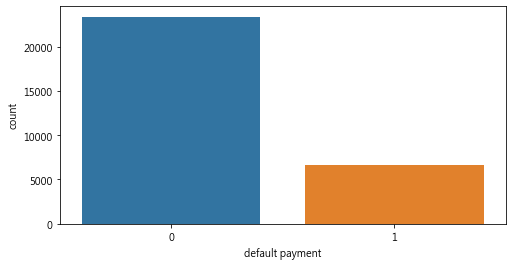

In [99]:
data = pd.read_csv('./UCI_Credit_Card.csv')
data.rename(columns={'default.payment.next.month':'target'}, inplace=True)
data.target.unique()
plt.figure(figsize=(8,4))
sb.countplot(x='target', data = data)
plt.xlabel('default payment')
plt.ylabel('count')
plt.show()

In [100]:
torch.manual_seed(1)    

num_epochs = 1000         
bs = 256
lr = 0.0001         
nw = 4
tp = 3
imbalance = 1

In [101]:
def normalize(df):
    for col in df.columns:
        if(col == 'target'):
            continue
        else:
            if(df[col].std() > 1000):
                df[col] = (df[col] - df[col].mean()) / df[col].std()
            else:
                df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    
    return df


In [102]:
# type 1
if(tp == 1):
    data = pd.read_csv('./UCI_Credit_Card.csv')
    data_1 = data[['PAY_0', 'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default.payment.next.month']]
    data_1.rename(columns={'default.payment.next.month':'target'}, inplace=True)
    data_train = data_1[:25000]
    data_test = data_1[25000:]
    x_train = np.array(data_train.drop('target', axis = 1))
    y_train = np.array(data_train['target'])
    x_test = np.array(data_test.drop('target', axis = 1))
    y_test = np.array(data_test['target'])
    #target : default payment(違約金) 1:違約 0:沒違約
    input_feature = 18
    data_1[:10]

In [103]:
# type 2
if(tp == 2):

    data_ = pd.read_csv('./UCI_Credit_Card.csv')
    data2 = data_[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default.payment.next.month']]
    data_2 = data_
    data_2.rename(columns={'default.payment.next.month':'target'}, inplace=True)
    data_2['D5'] = (data2['PAY_AMT5'] / data2['BILL_AMT6'])*100
    data_2['D4'] = (data2['PAY_AMT4'] / data2['BILL_AMT5'])*100
    data_2['D3'] = (data2['PAY_AMT3'] / data2['BILL_AMT4'])*100
    data_2['D2'] = (data2['PAY_AMT2'] / data2['BILL_AMT3'])*100
    data_2['D1'] = (data2['PAY_AMT1'] / data2['BILL_AMT2'])*100
    data_2 = data_2[['D1','D2','D3','D4','D5','target']]
    data_2.fillna(100,inplace=True)


    data_2 = data_2[data_2['D5']>=0]
    data_2 = data_2[data_2['D4']>=0]
    data_2 = data_2[data_2['D3']>=0]
    data_2 = data_2[data_2['D2']>=0]
    data_2 = data_2[data_2['D1']>=0]
    data_2 = data_2.reset_index()
    data_2 = data_2.drop(['index'],axis=1)


    data_train = data_2[:25000]
    data_test = data_2[25000:]
    x_train = np.array(data_train.drop('target', axis = 1))
    y_train = np.array(data_train['target'])
    x_test = np.array(data_test.drop('target', axis = 1))
    y_test = np.array(data_test['target'])
    input_feature = 5
    print(len(data_2))
    print(data_2[:10])

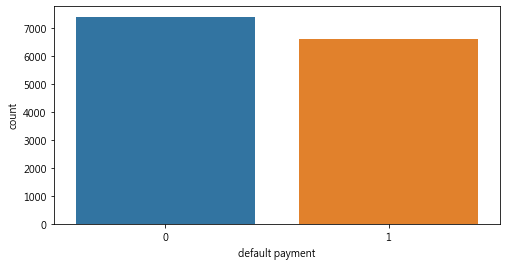

14000
             D1        D2        D3        D4        D5  SEX  EDUCATION  \
20670  0.735898  0.599922  0.712978  0.610021  0.712475  0.0   0.333333   
19569  0.735890  0.599928  0.712978  0.610021  0.712475  1.0   0.666667   
4154   0.623751  0.489515  0.658184  0.565971  0.647493  0.0   0.666667   
1547   0.710237  0.569894  0.672875  0.573361  0.656803  1.0   0.666667   
27659  0.638108  0.516296  0.607595  0.514200  0.573517  1.0   0.666667   
27285  0.629268  0.494221  0.612224  0.567821  0.646388  1.0   0.666667   
11130  0.629391  0.518056  0.622622  0.556622  0.641965  1.0   0.666667   
22022  0.701407  0.563470  0.666545  0.567597  0.647813  1.0   0.333333   
17998  0.726705  0.589421  0.697913  0.594593  0.688285  0.0   0.666667   
9056   0.735797  0.600049  0.712924  0.610058  0.711521  0.0   0.333333   

       MARRIAGE       AGE  target  
20670  0.333333  0.362069       0  
19569  0.333333  0.379310       0  
4154   0.666667  0.534483       1  
1547   0.333333  0.46551

In [104]:
# type 3
if(tp == 3):
    data_ = pd.read_csv('./UCI_Credit_Card.csv')
    data3 = data_[['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default.payment.next.month']]
    data_3 = data_
    data_3.rename(columns={'default.payment.next.month':'target'}, inplace=True)
    data_3['D5'] = (data3['PAY_AMT5'] - data3['BILL_AMT6']) / data3['LIMIT_BAL']
    data_3['D4'] = (data3['PAY_AMT4'] - data3['BILL_AMT5']) / data3['LIMIT_BAL']
    data_3['D3'] = (data3['PAY_AMT3'] - data3['BILL_AMT4']) / data3['LIMIT_BAL']
    data_3['D2'] = (data3['PAY_AMT2'] - data3['BILL_AMT3']) / data3['LIMIT_BAL']
    data_3['D1'] = (data3['PAY_AMT1'] - data3['BILL_AMT2']) / data3['LIMIT_BAL']
    data_3 = data_3[['D1','D2','D3','D4','D5','SEX','EDUCATION','MARRIAGE','AGE','target']]
    data_3 = data_3[data_3['EDUCATION']<=3]
    data_3 = data_3.reset_index()
    data_3 = data_3.drop(['index'],axis=1)
    data_3 = normalize(data_3)

    if(imbalance == 1):
        data_3 = data_3.sort_values(by=['target'],ascending=False)
        data_3 = data_3[:14000]
        data_3 = shuffle(data_3)
        split_point = 10000    
        data_3.target.unique()
        plt.figure(figsize=(8,4))
        sb.countplot(x='target', data = data_3)
        plt.xlabel('default payment')
        plt.ylabel('count')
        plt.show()
    else:
        split_point = 25000
   
    data_train = data_3[:split_point]
    data_test = data_3[split_point:]
    x_train = np.array(data_train.drop('target', axis = 1))
    y_train = np.array(data_train['target'])
    x_test = np.array(data_test.drop('target', axis = 1))
    y_test = np.array(data_test['target'])
    input_feature = 9
    print(len(data_3))
    print(data_3[:10])


In [105]:
data_3['target'].sum() #29546 - 6603 = 222943

6603

In [106]:
x_train = torch.from_numpy(x_train).reshape(-1,input_feature,1).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train.astype(np.float64)).view(-1,1).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).reshape(-1,input_feature,1).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.astype(np.float64)).view(-1,1).type(torch.FloatTensor)
y_train = y_train.long()
y_test = y_test.long()

train_data = data_utils.TensorDataset(x_train, y_train)
test_data = data_utils.TensorDataset(x_test, y_test)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

train_loader = data_utils.DataLoader(
    dataset = train_data,
    batch_size = bs,
    shuffle = True,
    num_workers = nw,
)

test_loader = data_utils.DataLoader(
    dataset = test_data,
    batch_size = 300,
    shuffle = True,
    num_workers = nw,
)


torch.Size([10000, 9, 1]) torch.Size([10000, 1])
torch.Size([4000, 9, 1]) torch.Size([4000, 1])


In [107]:
def acc_cal(predict,label):
    l = len(predict)
    acc_count = 0
    count = 0
    PP_ = 0
    PN_ = 0
    NP_ = 0
    NN_ = 0 
    for i in range(l):
        if(torch.argmax(output[i])== 1 and label[i]== 1):
            PP_ = PP_ + 1
            acc_count = acc_count + 1
        elif(torch.argmax(output[i])== 1 and label[i]== 0):
            NP_ = NP_ + 1
        elif(torch.argmax(output[i])== 0 and label[i]== 1):
            PN_ = PN_ + 1
        elif(torch.argmax(output[i])== 0 and label[i]== 0):
            NN_ = NN_ + 1
            acc_count = acc_count + 1
        count = count + 1
    return acc_count,count,PP_,PN_,NP_,NN_

def softmax(x):
    """Compute the softmax of vector x."""
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x 

def index_cal(pp_,pn_,np_,nn_):
    acc = (pp_ + nn_) / (pp_ + pn_ + np_ + nn_)
    precision = pp_ / (pp_ + np_)
    recall = pp_ / (pp_ + pn_)
    f1_score = 2 / (1/precision + 1/recall)
    return acc,precision,recall,f1_score

#重置參數用
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [108]:
class DNN(torch.nn.Module):     
    def __init__(self):
        super(DNN, self).__init__()
        self.dnn1 = nn.Sequential(
            nn.Linear(input_feature,36, bias = True),
            #nn.Dropout(0.5),
            nn.ReLU()
        )  
        
        self.dnn2 = nn.Sequential(  
            nn.Linear(36,108, bias = True),
            nn.Dropout(0.8),
            nn.ReLU()
        )
        
        self.dnn3 = nn.Sequential(  
            nn.Linear(108,2, bias = True),
            #nn.Dropout(0.5),
            #nn.Softmax()
            #nn.Sigmoid()
            #nn.ReLU()
        )
    def forward(self, x):
        
        x_1 = self.dnn1(x)
        x_2 = self.dnn2(x_1)   
        output = self.dnn3(x_2)               
        return output
    
dnn = DNN() 
print(dnn)  

DNN(
  (dnn1): Sequential(
    (0): Linear(in_features=9, out_features=36, bias=True)
    (1): ReLU()
  )
  (dnn2): Sequential(
    (0): Linear(in_features=36, out_features=108, bias=True)
    (1): Dropout(p=0.8, inplace=False)
    (2): ReLU()
  )
  (dnn3): Sequential(
    (0): Linear(in_features=108, out_features=2, bias=True)
  )
)


In [109]:
optimizer = torch.optim.Adam(dnn.parameters(), lr=lr)  
#optimizer = torch.optim.SGD(dnn.parameters(), lr=0.1, momentum=0.9)
loss_func = nn.CrossEntropyLoss() 
#loss_func = nn.BCEWithLogitsLoss() 
dnn.apply(weight_reset)
draw_loss = []
draw_acc_train = []
draw_acc_test = []
for epoch in range(num_epochs):#num_epochs
    acc_count_t = 0
    count_t = 0
    acc_count_t_test = 0
    count_t_test = 0    
    PP_ = 0
    PN_ = 0 
    NP_ = 0
    NN_ = 0
    PP_train = 0
    PN_train = 0 
    NP_train = 0
    NN_train = 0
    for iteration, (b_x, b_y) in enumerate(train_loader):   
        b_x = b_x.view(-1, input_feature)
        b_y = b_y.squeeze()
        #print(b_y)
        output = dnn(b_x)  
        loss = loss_func(output, b_y)  
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()                
        acc_count,count,pp_t,pn_t,np_t,nn_t = acc_cal(output,b_y)
        PP_train = PP_train + pp_t
        PN_train = PN_train + pn_t
        NP_train = NP_train + np_t
        NN_train = NN_train + nn_t
        acc_count_t = acc_count_t + acc_count
        count_t = count_t + count
        acc = acc_count_t / count_t
        """
        if(iteration == 1):
            acc1 = acc
        """

    for iteration, (b_x_test, b_y_test) in enumerate(test_loader):
        if(iteration == 10):
            break
        b_x_test = b_x_test.view(-1, input_feature)
        b_y_test = b_y_test.squeeze()
        output = dnn(b_x_test) 
        t1 = output.detach().numpy()
        t2 = b_y_test.detach().numpy()
        acc_count,count,pp_,pn_,np_,nn_ = acc_cal(output,b_y_test)
        PP_ = PP_ + pp_
        PN_ = PN_ + pn_
        NP_ = NP_ + np_
        NN_ = NN_ + nn_
        acc_count_t_test = acc_count_t_test + acc_count
        count_t_test = count_t_test + count
    acc_test = acc_count_t_test / count_t_test
    draw_loss.append(loss)
    draw_acc_train.append(acc)
    draw_acc_test.append(acc_test)
    print('acc_count_t_test',acc_count_t_test)
    print('count_t_test',count_t_test)
    print ('Epoch [{}/{}] , Loss: {:.4f} , Train_Acc: {:.4f}  , Test_Acc: {:.4f}' 
           .format(epoch+1, num_epochs, loss, acc, acc_test))

acc_count_t_test 1500
count_t_test 3000
Epoch [1/1000] , Loss: 0.7773 , Train_Acc: 0.5105  , Test_Acc: 0.5000
acc_count_t_test 1544
count_t_test 3000
Epoch [2/1000] , Loss: 0.6745 , Train_Acc: 0.5121  , Test_Acc: 0.5147
acc_count_t_test 1537
count_t_test 3000
Epoch [3/1000] , Loss: 0.7129 , Train_Acc: 0.5192  , Test_Acc: 0.5123
acc_count_t_test 1550
count_t_test 3000
Epoch [4/1000] , Loss: 0.6975 , Train_Acc: 0.5185  , Test_Acc: 0.5167
acc_count_t_test 1594
count_t_test 3000
Epoch [5/1000] , Loss: 0.6836 , Train_Acc: 0.5245  , Test_Acc: 0.5313
acc_count_t_test 1555
count_t_test 3000
Epoch [6/1000] , Loss: 0.6812 , Train_Acc: 0.5222  , Test_Acc: 0.5183
acc_count_t_test 1595
count_t_test 3000
Epoch [7/1000] , Loss: 0.7083 , Train_Acc: 0.5299  , Test_Acc: 0.5317
acc_count_t_test 1610
count_t_test 3000
Epoch [8/1000] , Loss: 0.7527 , Train_Acc: 0.5345  , Test_Acc: 0.5367
acc_count_t_test 1598
count_t_test 3000
Epoch [9/1000] , Loss: 0.6954 , Train_Acc: 0.5332  , Test_Acc: 0.5327
acc_count_

acc_count_t_test 1667
count_t_test 3000
Epoch [75/1000] , Loss: 0.6509 , Train_Acc: 0.5693  , Test_Acc: 0.5557
acc_count_t_test 1648
count_t_test 3000
Epoch [76/1000] , Loss: 0.6724 , Train_Acc: 0.5716  , Test_Acc: 0.5493
acc_count_t_test 1684
count_t_test 3000
Epoch [77/1000] , Loss: 0.7111 , Train_Acc: 0.5674  , Test_Acc: 0.5613
acc_count_t_test 1752
count_t_test 3000
Epoch [78/1000] , Loss: 0.6663 , Train_Acc: 0.5733  , Test_Acc: 0.5840
acc_count_t_test 1700
count_t_test 3000
Epoch [79/1000] , Loss: 0.6656 , Train_Acc: 0.5660  , Test_Acc: 0.5667
acc_count_t_test 1689
count_t_test 3000
Epoch [80/1000] , Loss: 0.6800 , Train_Acc: 0.5667  , Test_Acc: 0.5630
acc_count_t_test 1702
count_t_test 3000
Epoch [81/1000] , Loss: 0.6796 , Train_Acc: 0.5673  , Test_Acc: 0.5673
acc_count_t_test 1701
count_t_test 3000
Epoch [82/1000] , Loss: 0.7028 , Train_Acc: 0.5748  , Test_Acc: 0.5670
acc_count_t_test 1724
count_t_test 3000
Epoch [83/1000] , Loss: 0.6892 , Train_Acc: 0.5719  , Test_Acc: 0.5747
a

acc_count_t_test 1763
count_t_test 3000
Epoch [149/1000] , Loss: 0.6898 , Train_Acc: 0.5810  , Test_Acc: 0.5877
acc_count_t_test 1776
count_t_test 3000
Epoch [150/1000] , Loss: 0.6890 , Train_Acc: 0.5828  , Test_Acc: 0.5920
acc_count_t_test 1757
count_t_test 3000
Epoch [151/1000] , Loss: 0.6725 , Train_Acc: 0.5792  , Test_Acc: 0.5857
acc_count_t_test 1729
count_t_test 3000
Epoch [152/1000] , Loss: 0.6610 , Train_Acc: 0.5814  , Test_Acc: 0.5763
acc_count_t_test 1763
count_t_test 3000
Epoch [153/1000] , Loss: 0.6916 , Train_Acc: 0.5817  , Test_Acc: 0.5877
acc_count_t_test 1759
count_t_test 3000
Epoch [154/1000] , Loss: 0.6996 , Train_Acc: 0.5802  , Test_Acc: 0.5863
acc_count_t_test 1737
count_t_test 3000
Epoch [155/1000] , Loss: 0.6293 , Train_Acc: 0.5830  , Test_Acc: 0.5790
acc_count_t_test 1747
count_t_test 3000
Epoch [156/1000] , Loss: 0.7989 , Train_Acc: 0.5825  , Test_Acc: 0.5823
acc_count_t_test 1748
count_t_test 3000
Epoch [157/1000] , Loss: 0.7007 , Train_Acc: 0.5794  , Test_Acc:

acc_count_t_test 1766
count_t_test 3000
Epoch [223/1000] , Loss: 0.5864 , Train_Acc: 0.5832  , Test_Acc: 0.5887
acc_count_t_test 1754
count_t_test 3000
Epoch [224/1000] , Loss: 0.6603 , Train_Acc: 0.5913  , Test_Acc: 0.5847
acc_count_t_test 1765
count_t_test 3000
Epoch [225/1000] , Loss: 0.7238 , Train_Acc: 0.5891  , Test_Acc: 0.5883
acc_count_t_test 1768
count_t_test 3000
Epoch [226/1000] , Loss: 0.6028 , Train_Acc: 0.5872  , Test_Acc: 0.5893
acc_count_t_test 1794
count_t_test 3000
Epoch [227/1000] , Loss: 0.5524 , Train_Acc: 0.5891  , Test_Acc: 0.5980
acc_count_t_test 1835
count_t_test 3000
Epoch [228/1000] , Loss: 0.7268 , Train_Acc: 0.5864  , Test_Acc: 0.6117
acc_count_t_test 1776
count_t_test 3000
Epoch [229/1000] , Loss: 0.7344 , Train_Acc: 0.5866  , Test_Acc: 0.5920
acc_count_t_test 1744
count_t_test 3000
Epoch [230/1000] , Loss: 0.6524 , Train_Acc: 0.5879  , Test_Acc: 0.5813
acc_count_t_test 1765
count_t_test 3000
Epoch [231/1000] , Loss: 0.6122 , Train_Acc: 0.5858  , Test_Acc:

acc_count_t_test 1788
count_t_test 3000
Epoch [297/1000] , Loss: 0.7756 , Train_Acc: 0.5909  , Test_Acc: 0.5960
acc_count_t_test 1771
count_t_test 3000
Epoch [298/1000] , Loss: 0.5981 , Train_Acc: 0.5873  , Test_Acc: 0.5903
acc_count_t_test 1769
count_t_test 3000
Epoch [299/1000] , Loss: 0.6272 , Train_Acc: 0.5878  , Test_Acc: 0.5897
acc_count_t_test 1778
count_t_test 3000
Epoch [300/1000] , Loss: 0.6898 , Train_Acc: 0.5873  , Test_Acc: 0.5927
acc_count_t_test 1774
count_t_test 3000
Epoch [301/1000] , Loss: 0.7248 , Train_Acc: 0.5915  , Test_Acc: 0.5913
acc_count_t_test 1780
count_t_test 3000
Epoch [302/1000] , Loss: 0.6518 , Train_Acc: 0.5893  , Test_Acc: 0.5933
acc_count_t_test 1760
count_t_test 3000
Epoch [303/1000] , Loss: 0.7177 , Train_Acc: 0.5909  , Test_Acc: 0.5867
acc_count_t_test 1786
count_t_test 3000
Epoch [304/1000] , Loss: 0.7306 , Train_Acc: 0.5893  , Test_Acc: 0.5953
acc_count_t_test 1738
count_t_test 3000
Epoch [305/1000] , Loss: 0.6659 , Train_Acc: 0.5889  , Test_Acc:

acc_count_t_test 1767
count_t_test 3000
Epoch [371/1000] , Loss: 0.6612 , Train_Acc: 0.5912  , Test_Acc: 0.5890
acc_count_t_test 1795
count_t_test 3000
Epoch [372/1000] , Loss: 0.6684 , Train_Acc: 0.5925  , Test_Acc: 0.5983
acc_count_t_test 1810
count_t_test 3000
Epoch [373/1000] , Loss: 0.6719 , Train_Acc: 0.5928  , Test_Acc: 0.6033
acc_count_t_test 1783
count_t_test 3000
Epoch [374/1000] , Loss: 0.7109 , Train_Acc: 0.5892  , Test_Acc: 0.5943
acc_count_t_test 1780
count_t_test 3000
Epoch [375/1000] , Loss: 0.5595 , Train_Acc: 0.5908  , Test_Acc: 0.5933
acc_count_t_test 1788
count_t_test 3000
Epoch [376/1000] , Loss: 0.5286 , Train_Acc: 0.5947  , Test_Acc: 0.5960
acc_count_t_test 1769
count_t_test 3000
Epoch [377/1000] , Loss: 0.6642 , Train_Acc: 0.5915  , Test_Acc: 0.5897
acc_count_t_test 1797
count_t_test 3000
Epoch [378/1000] , Loss: 0.6569 , Train_Acc: 0.5910  , Test_Acc: 0.5990
acc_count_t_test 1808
count_t_test 3000
Epoch [379/1000] , Loss: 0.7351 , Train_Acc: 0.5901  , Test_Acc:

acc_count_t_test 1752
count_t_test 3000
Epoch [445/1000] , Loss: 0.6989 , Train_Acc: 0.5906  , Test_Acc: 0.5840
acc_count_t_test 1765
count_t_test 3000
Epoch [446/1000] , Loss: 0.6576 , Train_Acc: 0.5928  , Test_Acc: 0.5883
acc_count_t_test 1763
count_t_test 3000
Epoch [447/1000] , Loss: 0.6385 , Train_Acc: 0.5890  , Test_Acc: 0.5877
acc_count_t_test 1786
count_t_test 3000
Epoch [448/1000] , Loss: 0.6077 , Train_Acc: 0.5908  , Test_Acc: 0.5953
acc_count_t_test 1810
count_t_test 3000
Epoch [449/1000] , Loss: 0.6911 , Train_Acc: 0.5898  , Test_Acc: 0.6033
acc_count_t_test 1770
count_t_test 3000
Epoch [450/1000] , Loss: 0.7413 , Train_Acc: 0.5954  , Test_Acc: 0.5900
acc_count_t_test 1774
count_t_test 3000
Epoch [451/1000] , Loss: 0.7551 , Train_Acc: 0.5921  , Test_Acc: 0.5913
acc_count_t_test 1781
count_t_test 3000
Epoch [452/1000] , Loss: 0.6633 , Train_Acc: 0.5934  , Test_Acc: 0.5937
acc_count_t_test 1747
count_t_test 3000
Epoch [453/1000] , Loss: 0.6463 , Train_Acc: 0.5900  , Test_Acc:

acc_count_t_test 1785
count_t_test 3000
Epoch [519/1000] , Loss: 0.6322 , Train_Acc: 0.5936  , Test_Acc: 0.5950
acc_count_t_test 1784
count_t_test 3000
Epoch [520/1000] , Loss: 0.6643 , Train_Acc: 0.5905  , Test_Acc: 0.5947
acc_count_t_test 1777
count_t_test 3000
Epoch [521/1000] , Loss: 0.6357 , Train_Acc: 0.5946  , Test_Acc: 0.5923
acc_count_t_test 1772
count_t_test 3000
Epoch [522/1000] , Loss: 0.8003 , Train_Acc: 0.5919  , Test_Acc: 0.5907
acc_count_t_test 1780
count_t_test 3000
Epoch [523/1000] , Loss: 0.6204 , Train_Acc: 0.5912  , Test_Acc: 0.5933
acc_count_t_test 1799
count_t_test 3000
Epoch [524/1000] , Loss: 0.6398 , Train_Acc: 0.5951  , Test_Acc: 0.5997
acc_count_t_test 1793
count_t_test 3000
Epoch [525/1000] , Loss: 0.6253 , Train_Acc: 0.5926  , Test_Acc: 0.5977
acc_count_t_test 1803
count_t_test 3000
Epoch [526/1000] , Loss: 0.6052 , Train_Acc: 0.5934  , Test_Acc: 0.6010
acc_count_t_test 1799
count_t_test 3000
Epoch [527/1000] , Loss: 0.7499 , Train_Acc: 0.5918  , Test_Acc:

acc_count_t_test 1773
count_t_test 3000
Epoch [593/1000] , Loss: 0.5859 , Train_Acc: 0.5955  , Test_Acc: 0.5910
acc_count_t_test 1756
count_t_test 3000
Epoch [594/1000] , Loss: 0.6190 , Train_Acc: 0.5971  , Test_Acc: 0.5853
acc_count_t_test 1785
count_t_test 3000
Epoch [595/1000] , Loss: 0.6632 , Train_Acc: 0.5923  , Test_Acc: 0.5950
acc_count_t_test 1788
count_t_test 3000
Epoch [596/1000] , Loss: 0.5900 , Train_Acc: 0.5931  , Test_Acc: 0.5960
acc_count_t_test 1745
count_t_test 3000
Epoch [597/1000] , Loss: 0.7008 , Train_Acc: 0.5936  , Test_Acc: 0.5817
acc_count_t_test 1806
count_t_test 3000
Epoch [598/1000] , Loss: 0.6716 , Train_Acc: 0.5931  , Test_Acc: 0.6020
acc_count_t_test 1770
count_t_test 3000
Epoch [599/1000] , Loss: 0.6942 , Train_Acc: 0.5936  , Test_Acc: 0.5900
acc_count_t_test 1775
count_t_test 3000
Epoch [600/1000] , Loss: 0.6609 , Train_Acc: 0.5929  , Test_Acc: 0.5917
acc_count_t_test 1787
count_t_test 3000
Epoch [601/1000] , Loss: 0.6957 , Train_Acc: 0.5932  , Test_Acc:

acc_count_t_test 1787
count_t_test 3000
Epoch [667/1000] , Loss: 0.6962 , Train_Acc: 0.5923  , Test_Acc: 0.5957
acc_count_t_test 1761
count_t_test 3000
Epoch [668/1000] , Loss: 0.6292 , Train_Acc: 0.5944  , Test_Acc: 0.5870
acc_count_t_test 1768
count_t_test 3000
Epoch [669/1000] , Loss: 0.6614 , Train_Acc: 0.5923  , Test_Acc: 0.5893
acc_count_t_test 1797
count_t_test 3000
Epoch [670/1000] , Loss: 0.6065 , Train_Acc: 0.5926  , Test_Acc: 0.5990
acc_count_t_test 1776
count_t_test 3000
Epoch [671/1000] , Loss: 0.5481 , Train_Acc: 0.5951  , Test_Acc: 0.5920
acc_count_t_test 1793
count_t_test 3000
Epoch [672/1000] , Loss: 0.7194 , Train_Acc: 0.5934  , Test_Acc: 0.5977
acc_count_t_test 1816
count_t_test 3000
Epoch [673/1000] , Loss: 0.6173 , Train_Acc: 0.5948  , Test_Acc: 0.6053
acc_count_t_test 1773
count_t_test 3000
Epoch [674/1000] , Loss: 0.6712 , Train_Acc: 0.5951  , Test_Acc: 0.5910
acc_count_t_test 1780
count_t_test 3000
Epoch [675/1000] , Loss: 0.6858 , Train_Acc: 0.5917  , Test_Acc:

acc_count_t_test 1763
count_t_test 3000
Epoch [741/1000] , Loss: 0.5792 , Train_Acc: 0.5928  , Test_Acc: 0.5877
acc_count_t_test 1791
count_t_test 3000
Epoch [742/1000] , Loss: 0.6471 , Train_Acc: 0.5949  , Test_Acc: 0.5970
acc_count_t_test 1762
count_t_test 3000
Epoch [743/1000] , Loss: 0.7345 , Train_Acc: 0.5928  , Test_Acc: 0.5873
acc_count_t_test 1791
count_t_test 3000
Epoch [744/1000] , Loss: 0.6127 , Train_Acc: 0.5936  , Test_Acc: 0.5970
acc_count_t_test 1773
count_t_test 3000
Epoch [745/1000] , Loss: 0.7015 , Train_Acc: 0.5932  , Test_Acc: 0.5910
acc_count_t_test 1769
count_t_test 3000
Epoch [746/1000] , Loss: 0.7293 , Train_Acc: 0.5954  , Test_Acc: 0.5897
acc_count_t_test 1798
count_t_test 3000
Epoch [747/1000] , Loss: 0.6796 , Train_Acc: 0.5920  , Test_Acc: 0.5993
acc_count_t_test 1791
count_t_test 3000
Epoch [748/1000] , Loss: 0.6325 , Train_Acc: 0.5965  , Test_Acc: 0.5970
acc_count_t_test 1801
count_t_test 3000
Epoch [749/1000] , Loss: 0.7281 , Train_Acc: 0.5928  , Test_Acc:

acc_count_t_test 1747
count_t_test 3000
Epoch [815/1000] , Loss: 0.7052 , Train_Acc: 0.5943  , Test_Acc: 0.5823
acc_count_t_test 1792
count_t_test 3000
Epoch [816/1000] , Loss: 0.6662 , Train_Acc: 0.5938  , Test_Acc: 0.5973
acc_count_t_test 1790
count_t_test 3000
Epoch [817/1000] , Loss: 0.7589 , Train_Acc: 0.5909  , Test_Acc: 0.5967
acc_count_t_test 1796
count_t_test 3000
Epoch [818/1000] , Loss: 0.6426 , Train_Acc: 0.5917  , Test_Acc: 0.5987
acc_count_t_test 1766
count_t_test 3000
Epoch [819/1000] , Loss: 0.7030 , Train_Acc: 0.6004  , Test_Acc: 0.5887
acc_count_t_test 1793
count_t_test 3000
Epoch [820/1000] , Loss: 0.6749 , Train_Acc: 0.5942  , Test_Acc: 0.5977
acc_count_t_test 1808
count_t_test 3000
Epoch [821/1000] , Loss: 0.6357 , Train_Acc: 0.5957  , Test_Acc: 0.6027
acc_count_t_test 1799
count_t_test 3000
Epoch [822/1000] , Loss: 0.7568 , Train_Acc: 0.5946  , Test_Acc: 0.5997
acc_count_t_test 1809
count_t_test 3000
Epoch [823/1000] , Loss: 0.6205 , Train_Acc: 0.5923  , Test_Acc:

acc_count_t_test 1795
count_t_test 3000
Epoch [889/1000] , Loss: 0.6724 , Train_Acc: 0.5953  , Test_Acc: 0.5983
acc_count_t_test 1758
count_t_test 3000
Epoch [890/1000] , Loss: 0.6486 , Train_Acc: 0.5922  , Test_Acc: 0.5860
acc_count_t_test 1797
count_t_test 3000
Epoch [891/1000] , Loss: 0.7154 , Train_Acc: 0.5942  , Test_Acc: 0.5990
acc_count_t_test 1782
count_t_test 3000
Epoch [892/1000] , Loss: 0.7921 , Train_Acc: 0.5929  , Test_Acc: 0.5940
acc_count_t_test 1796
count_t_test 3000
Epoch [893/1000] , Loss: 0.7195 , Train_Acc: 0.5939  , Test_Acc: 0.5987
acc_count_t_test 1761
count_t_test 3000
Epoch [894/1000] , Loss: 0.7456 , Train_Acc: 0.5948  , Test_Acc: 0.5870
acc_count_t_test 1777
count_t_test 3000
Epoch [895/1000] , Loss: 0.5777 , Train_Acc: 0.5926  , Test_Acc: 0.5923
acc_count_t_test 1751
count_t_test 3000
Epoch [896/1000] , Loss: 0.6816 , Train_Acc: 0.5928  , Test_Acc: 0.5837
acc_count_t_test 1765
count_t_test 3000
Epoch [897/1000] , Loss: 0.7118 , Train_Acc: 0.5944  , Test_Acc:

acc_count_t_test 1766
count_t_test 3000
Epoch [963/1000] , Loss: 0.6704 , Train_Acc: 0.5939  , Test_Acc: 0.5887
acc_count_t_test 1763
count_t_test 3000
Epoch [964/1000] , Loss: 0.6695 , Train_Acc: 0.5947  , Test_Acc: 0.5877
acc_count_t_test 1745
count_t_test 3000
Epoch [965/1000] , Loss: 0.6310 , Train_Acc: 0.5981  , Test_Acc: 0.5817
acc_count_t_test 1732
count_t_test 3000
Epoch [966/1000] , Loss: 0.6852 , Train_Acc: 0.5973  , Test_Acc: 0.5773
acc_count_t_test 1768
count_t_test 3000
Epoch [967/1000] , Loss: 0.6950 , Train_Acc: 0.5965  , Test_Acc: 0.5893
acc_count_t_test 1792
count_t_test 3000
Epoch [968/1000] , Loss: 0.7763 , Train_Acc: 0.5999  , Test_Acc: 0.5973
acc_count_t_test 1775
count_t_test 3000
Epoch [969/1000] , Loss: 0.7218 , Train_Acc: 0.5966  , Test_Acc: 0.5917
acc_count_t_test 1759
count_t_test 3000
Epoch [970/1000] , Loss: 0.5836 , Train_Acc: 0.5968  , Test_Acc: 0.5863
acc_count_t_test 1774
count_t_test 3000
Epoch [971/1000] , Loss: 0.5790 , Train_Acc: 0.5900  , Test_Acc:

In [110]:
acc,precision,recall,f1_score = index_cal(PP_train,PN_train,NP_train,NN_train)
print("train")
print('PP',PP_)
print('PN',PN_)
print('NP',NP_)
print('NN',NN_)
print('acc',acc)
print('precision',precision)
print('recall',recall)
print('f1_score',f1_score)
fpr, tpr, thresholds = metrics.roc_curve(t2,t1[:,1],pos_label=1)
print('auc',metrics.auc(fpr, tpr))

train
PP 626
PN 799
NP 433
NN 1142
acc 0.5959
precision 0.5938281901584654
recall 0.4529262086513995
f1_score 0.5138939011187297
auc 0.6144589053307185


In [111]:
acc,precision,recall,f1_score = index_cal(PP_,PN_,NP_,NN_)
print("testing")
print('PP',PP_)
print('PN',PN_)
print('NP',NP_)
print('NN',NN_)
print('acc',acc)
print('precision',precision)
print('recall',recall)
print('f1_score',f1_score)
fpr, tpr, thresholds = metrics.roc_curve(t2,t1[:,1],pos_label=1)
print('auc',metrics.auc(fpr, tpr))

testing
PP 626
PN 799
NP 433
NN 1142
acc 0.5893333333333334
precision 0.591123701605288
recall 0.4392982456140351
f1_score 0.5040257648953301
auc 0.6144589053307185


In [112]:
print("testing")
print('PP',PP_)
print('PN',PN_)
print('NP',NP_)
print('NN',NN_)

testing
PP 626
PN 799
NP 433
NN 1142


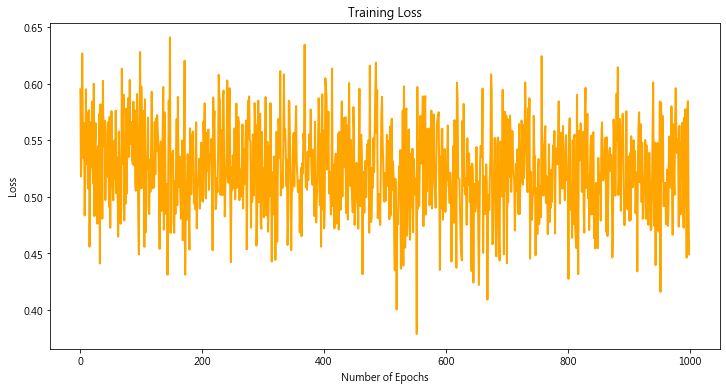

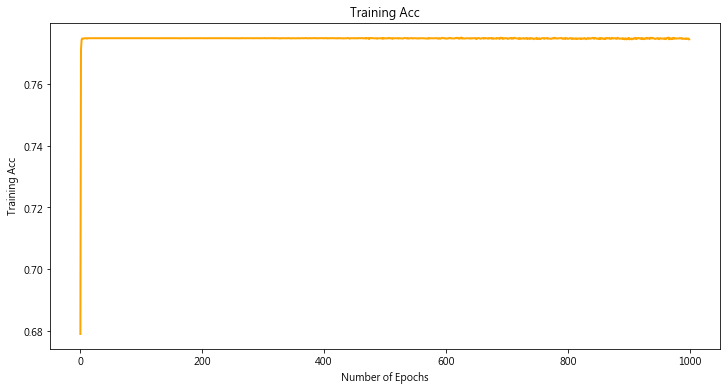

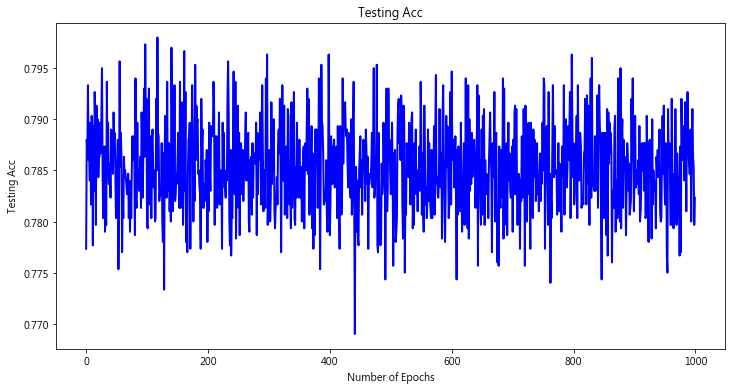

In [97]:
plt.figure(figsize=(12,6))
plt.plot(draw_loss, color='orange', lw=2)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
#plt.savefig("Vanilla_DNN_loss_imbalance")
plt.savefig("Vanilla_DNN_train_acc_balance")


plt.figure(figsize=(12,6))
plt.plot(draw_acc_train, color='orange', lw=2)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Acc")
plt.title("Training Acc")
#plt.savefig("Vanilla_DNN_train_acc_imbalance")
plt.savefig("Vanilla_DNN_train_acc_balance")

plt.figure(figsize=(12,6))
plt.plot(draw_acc_test, color='blue', lw=2)
plt.xlabel("Number of Epochs")
plt.ylabel("Testing Acc")
plt.title("Testing Acc")
#plt.savefig("Vanilla_DNN_test_acc_imbalance")
plt.savefig("Vanilla_DNN_train_acc_balance")
